In [1]:
import sys; sys.path.append('..')
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

from simulator import ContextualWebServer, BanditSimulator
from policy import LinUCB, LinThompsonSampling
from ope_estimator import (
    DirectMethod as DM,
    InversePropensityScore as IPS,
    DoublyRobust as DR,
    GBCModel,
    GBRModel
)

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# settings

# data generation
n_action=50
dim_user_context=20
dim_context=20
reward_type="binary"
noise_ver=1.

# LinUCB (behavior policy)
noise_zero_ver=1.0
alpha=5

# LinTS (new policy)
noise_zero_ver=1.0

# batch size
batch_size=1

# GBR and GBC for reward_hat, pi_b_hat
n_estimators=100
max_depth=5
gbr_lr=0.2
gbc_lr=0.2

In [3]:
# web server
web_server = ContextualWebServer(
    n_action=n_action,
    dim_user_context=dim_user_context,
    dim_context=dim_context,
    reward_type=reward_type,
    noise_ver=noise_ver
)

In [4]:
datasizes = [250, 500, 1000, 2000]
n_sim=10
result_dict = defaultdict(lambda: defaultdict(list))

for datasize in tqdm(datasizes):
    
    behavior_policy = LinUCB(
        n_action=n_action,
        dim_context=dim_context,
        noise_ver=noise_ver,
        noise_zero_ver=noise_zero_ver,
        alpha=alpha,
    )
    
    # generate stationary bandit data
    simulator = BanditSimulator(
        n_round=datasize,
        batch_size=batch_size,
        n_action=n_action
    )
    simulator.run(policy=behavior_policy, web_server=web_server)
    bandit_data = simulator.observed_data
    
    propensity_model = GBCModel(
        n_estimators=n_estimators,
        max_depth=max_depth,
        lr=gbc_lr
    )

    pi_b = propensity_model.fit(contexts=bandit_data["context"], actions=bandit_data["action"])
    
    # predict reward
    q_hat_model = GBRModel(
        n_action=n_action,
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        lr=gbr_lr
    )
    rewards_hats = q_hat_model.fit_predict(
        contexts=bandit_data["context"],
        actions=bandit_data["action"],
        rewards=bandit_data["reward"]
    )

    metric_dict = defaultdict(list)
    for _ in range(n_sim):
        new_policy = LinThompsonSampling(
            n_action=n_action,
            dim_context=dim_context,
            noise_ver=noise_ver,
            noise_zero_ver=noise_zero_ver,
        )
        
        input_data = {
            "DM": {"contexts": bandit_data["context"], "rewards_hats": rewards_hats},
            "IPS": {"contexts": bandit_data["context"], "actions": bandit_data["action"], "rewards": bandit_data["reward"], "pi_b_hats": pi_b},
            "DR": {"contexts": bandit_data["context"], "actions": bandit_data["action"], "rewards": bandit_data["reward"], "pi_b_hats": pi_b, "rewards_hats": rewards_hats}
        }
        estimators = {"DM": DM(n_action=n_action, policy=new_policy), "IPS": IPS(n_action=n_action, policy=new_policy), "DR": DR(n_action=n_action, policy=new_policy)}
        
        # estimate policy value
        for estimator_name, estimator in estimators.items():
            estimated_value = estimator.estimate(**input_data[estimator_name])
            metric_dict[estimator_name].append(estimated_value)

        # ground truth
        simulator.run(policy=new_policy, web_server=web_server)
        online_score = simulator.observed_data["reward"].mean()
        metric_dict["Ground Truth"].append(online_score)
    
    metric_dict = {key: np.array(values) for key, values in metric_dict.items()}
    policy_value = metric_dict["Ground Truth"].mean()
    
    for estimator_name in ["DM", "IPS", "DR"]:
        bias = (metric_dict[estimator_name].mean() - policy_value) ** 2
        var = metric_dict[estimator_name].var()
        mse = var + bias
        
        mse_dict = {"MSE": mse, "Squared Bias": bias, "Variance": var}
        for metric_name, metrics in mse_dict.items():
            result_dict[estimator_name][metric_name].append(metrics)

100% 4/4 [13:34<00:00, 203.53s/it]


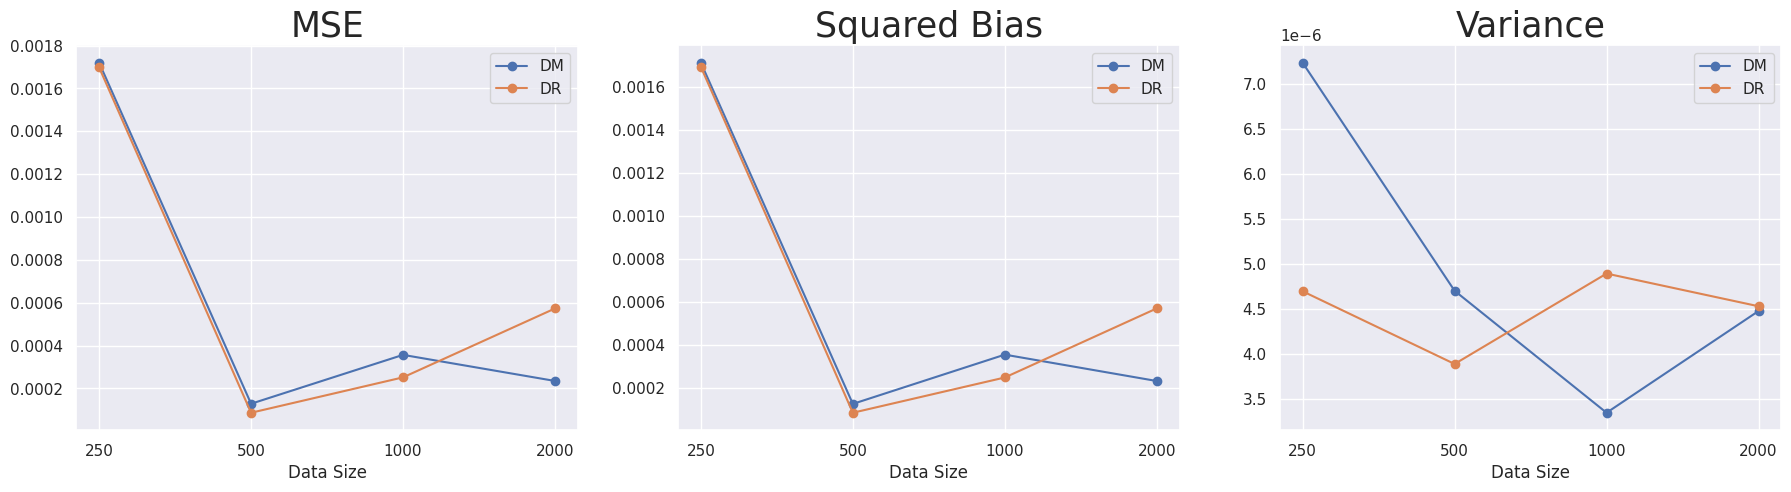

In [5]:
plt.figure(figsize=(22,5))

for i, metric_name in enumerate(["MSE", "Squared Bias", "Variance"]):
    
    plt.subplot(1,3,i + 1)
    for estimator_name, values in result_dict.items():
        if estimator_name == "IPS":
            continue
        plt.plot(result_dict[estimator_name][metric_name], label=estimator_name, marker="o")
        plt.title(metric_name, fontsize=25)
        plt.xlabel('Data Size')
        plt.xticks(range(len(datasizes)), datasizes)
        plt.legend()
plt.show()